# Bank Marketing Campaign Optimization

### Import libraries & data

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

### Import data

In [2]:
df = pd.read_csv("bank-additional-full.csv", sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Check class imbalance

y
0    36537
1     4639
Name: count, dtype: int64

Class distribution (%):
y
0    88.733728
1    11.266272
Name: proportion, dtype: float64


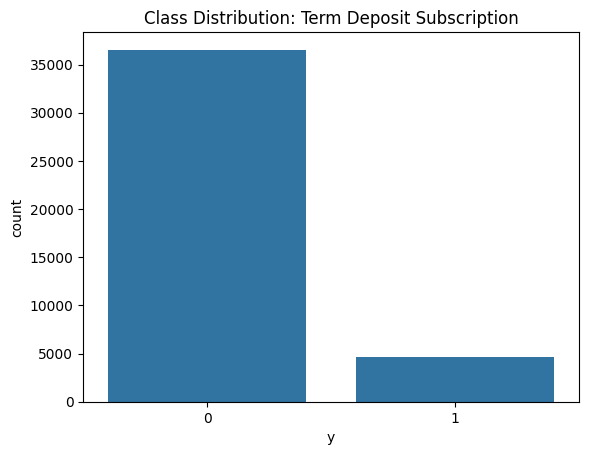

In [9]:
print(df['y'].value_counts())
print("\nClass distribution (%):")
print(df['y'].value_counts(normalize=True) * 100)

sns.countplot(x='y', data=df)
plt.title("Class Distribution: Term Deposit Subscription")
plt.show()

### Basic data cleaning

In [3]:
df = df.drop_duplicates()
df = df.fillna("unknown")

### Encode categorical features

In [4]:
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

### Train-test split

In [5]:
# X = df.drop('y', axis=1)
# y = df['y']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
from sklearn.model_selection import train_test_split
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Apply SMOTE

In [13]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", y_train_res.value_counts())

Before SMOTE:
 y
0    29229
1     3711
Name: count, dtype: int64

After SMOTE:
 y
0    29229
1    29229
Name: count, dtype: int64


### Train ML model

In [10]:
# model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # weighted
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))
# print("ROC-AUC:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7265
           1       0.68      0.43      0.53       971

    accuracy                           0.91      8236
   macro avg       0.80      0.70      0.74      8236
weighted avg       0.90      0.91      0.90      8236

ROC-AUC: 0.7029533696751563


Applying `class_weight='balanced'` maintained overall accuracy (~91%) but led to minor changes in minority-class performance (recall 0.50 → 0.43, ROC-AUC 0.73 → 0.70).  
This indicates that class weighting alone did not substantially improve sensitivity to positive cases, suggesting a need for resampling (e.g., SMOTE) or model tuning for better recall.

In [14]:
# Train model on resampled data
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)

# Evaluate on original (unbalanced) test data
from sklearn.metrics import classification_report, roc_auc_score
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7308
           1       0.59      0.66      0.62       928

    accuracy                           0.91      8236
   macro avg       0.77      0.80      0.78      8236
weighted avg       0.91      0.91      0.91      8236

ROC-AUC: 0.8000478927203064


After applying SMOTE to balance the training data (~50/50), model performance on the original test set improved:

- Recall for positive class (subscribers) increased from ~0.43 to 0.66
- F1-score rose from ~0.53 to 0.62
- ROC-AUC improved from ~0.70 to 0.80

Although precision dropped slightly (0.68 → 0.59), the model now detects a much larger share of true depositors, making it more useful for targeted marketing campaigns.

### ROC and Precison-Recall curves

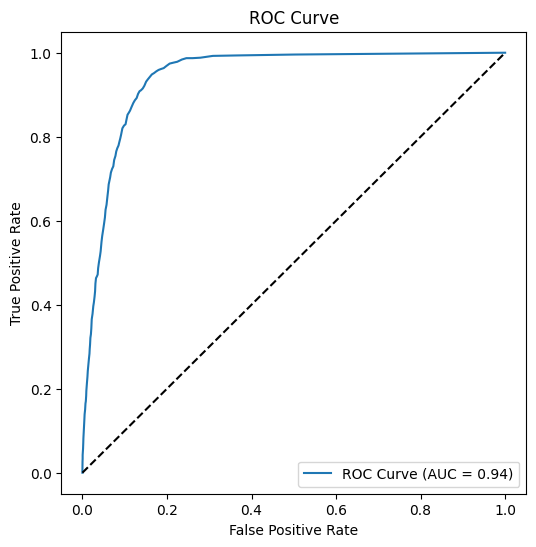

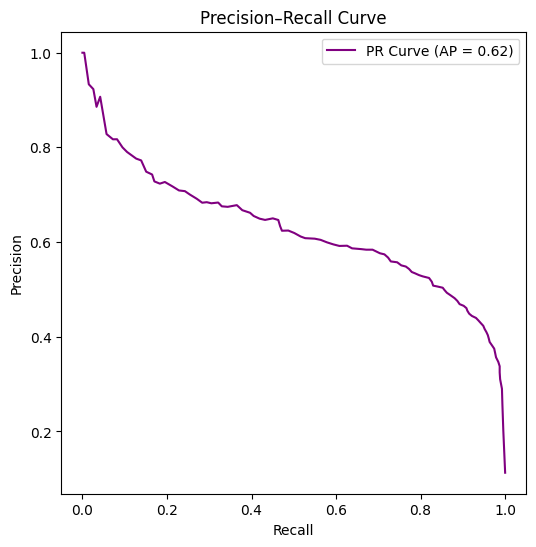

In [21]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

# Plot ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Plot Precision–Recall
plt.figure(figsize=(6,6))
plt.plot(recall, precision, label=f"PR Curve (AP = {avg_precision:.2f})", color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()


### Feature importance

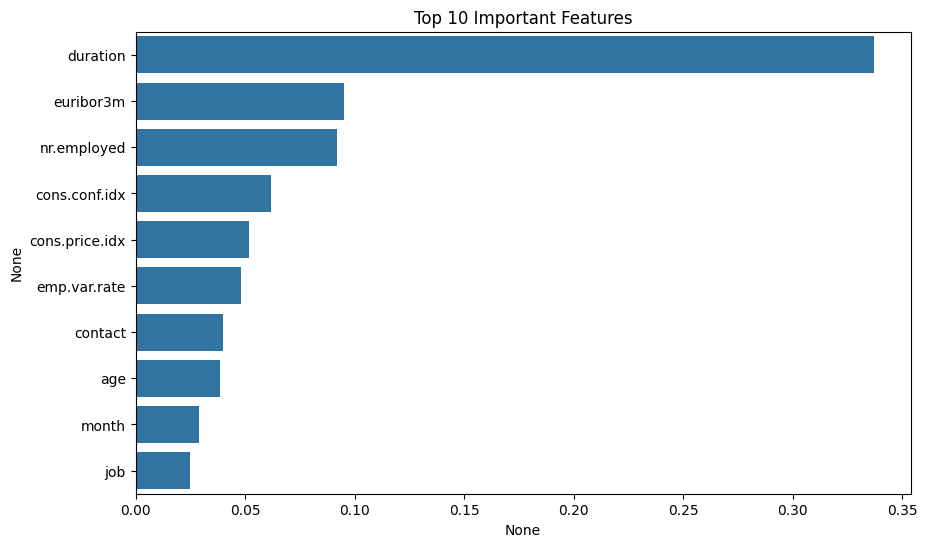

In [15]:
feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
plt.title("Top 10 Important Features")
plt.show()

### Save the model

In [16]:
joblib.dump(model, "bank_marketing_model.pkl")

['bank_marketing_model.pkl']